Importing the libraries and then exporting the dataset to the drive


In [ ]:
!pip install kagglehub

import kagglehub
from google.colab import drive
import shutil
import os

drive.mount('/content/drive')

# ==============================
# 3️⃣ Download Dataset using KaggleHub
# ==============================
path = kagglehub.dataset_download("hmsolanki/indian-languages-audio-dataset")
print("✅ Dataset downloaded to:", path)

# ==============================
# 4️⃣ Copy Dataset to Drive
# ==============================
# Destination folder in your Drive
drive_dataset_path = "/content/drive/MyDrive/Indian_Languages_Audio_Dataset"

# Copy all files from KaggleHub download path to Drive
shutil.copytree(path, drive_dataset_path, dirs_exist_ok=True)

print(f"✅ Dataset successfully copied to your Drive at: {drive_dataset_path}")


installing the required libraries

In [8]:
!pip install librosa soundfile joblib


importing the required libraries

In [9]:
import numpy as np
import os
import librosa
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout


dataset path

In [10]:
dataset_path = "/content/drive/MyDrive/Indian_Languages_Audio_Dataset/Indian_Languages_Audio_Dataset"


feature extraction

In [11]:
languages = sorted([
    d for d in os.listdir(dataset_path)
    if os.path.isdir(os.path.join(dataset_path, d))
])

print("Detected Languages:", languages)

data = []
labels = []

for lang in languages:
    folder = os.path.join(dataset_path, lang)
    print(f"\n📂 Processing: {lang}")

    for file in os.listdir(folder):
        if file.endswith((".mp3", ".wav")):

            file_path = os.path.join(folder, file)

            try:
                y, sr = librosa.load(file_path, duration=3, offset=0.5)
                mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)

                data.append(mfcc)
                labels.append(lang)

            except Exception as e:
                print("Error:", file_path, e)


Detected Languages: ['Bengali', 'Gujarati', 'Hindi', 'Kannada', 'Malayalam', 'Marathi', 'Punjabi', 'Tamil', 'Telugu', 'Urdu']

📂 Processing: Bengali

📂 Processing: Gujarati

📂 Processing: Hindi

📂 Processing: Kannada

📂 Processing: Malayalam

📂 Processing: Marathi

📂 Processing: Punjabi

📂 Processing: Tamil

📂 Processing: Telugu

📂 Processing: Urdu


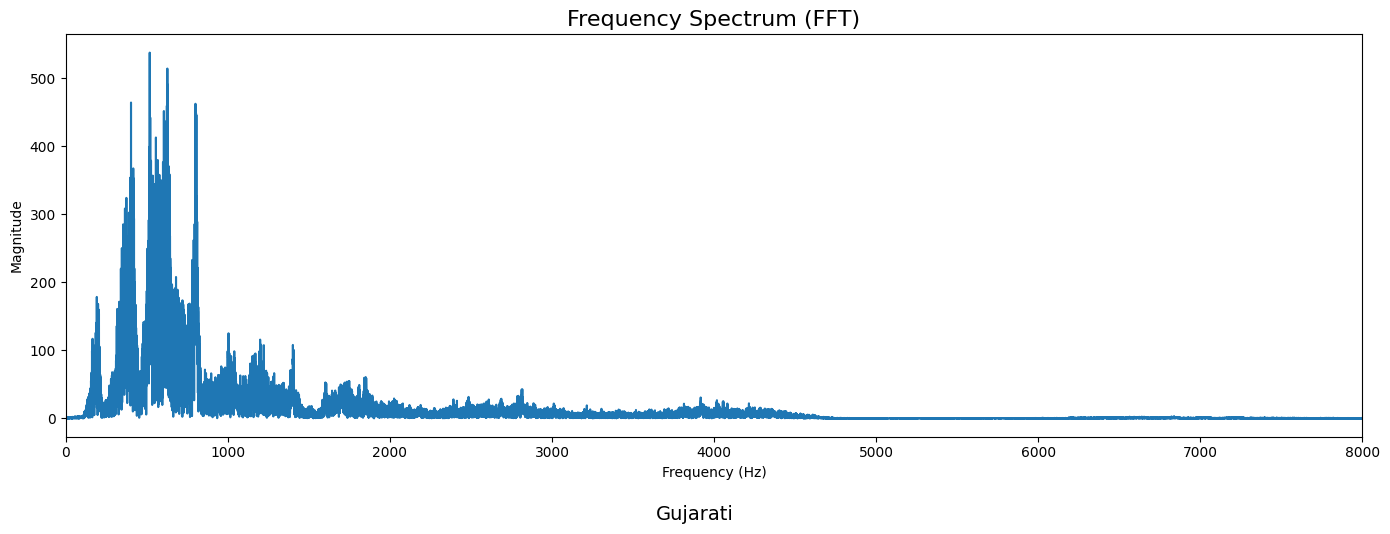

In [12]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

file = "/content/drive/MyDrive/Indian_Languages_Audio_Dataset/Indian_Languages_Audio_Dataset/Gujarati/10013.mp3"

# Load audio
audio, sr = librosa.load(file)

# Perform FFT
fft = np.fft.fft(audio)
magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))

# Keep only the first half (positive frequencies)
half_freq = frequency[:len(frequency)//2]
half_magnitude = magnitude[:len(magnitude)//2]

# Plot Frequency Spectrum
plt.figure(figsize=(14, 5))
plt.plot(half_freq, half_magnitude)
plt.title("Frequency Spectrum (FFT)", fontsize=16)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, 8000)  # Human speech range
plt.tight_layout()
plt.figtext(0.5, -0.05, "Gujarati", ha="center", fontsize=14)

plt.show()


Data Preparation for Training

In [12]:
X = np.array(data)
y = np.array(labels)

# Encode language names → numbers → one-hot vectors
label_encoder = LabelEncoder()
y_encoded = to_categorical(label_encoder.fit_transform(y))

# LSTM input shape: (samples, 40, 1)
X = np.expand_dims(X, axis=2)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (8000, 40, 1)
Test shape: (2000, 40, 1)


LSTM Model Construction

In [13]:
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(languages), activation='softmax')
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,994 (1.17 MB)

 Trainable params: 305,994 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

Training the Model

In [14]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=32,
    verbose=1
)


Epoch 1/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.2527 - loss: 2.0035 - val_accuracy: 0.4715 - val_loss: 1.4638
Epoch 2/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4210 - loss: 1.5316 - val_accuracy: 0.5500 - val_loss: 1.1996
Epoch 3/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4918 - loss: 1.3342 - val_accuracy: 0.5805 - val_loss: 1.1272
Epoch 4/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5411 - loss: 1.2031 - val_accuracy: 0.6155 - val_loss: 1.0006
Epoch 5/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6058 - loss: 1.0720 - val_accuracy: 0.6725 - val_loss: 0.9063
Epoch 6/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6491 - loss: 0.9569 - val_accuracy: 0.7080 - val_loss: 0.7908
Epoch 7/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6886 - loss: 0.8576 - val_accuracy: 0.7130 - val_loss: 0.7333
Epoch 8/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7213 - loss: 0.7645 - val_accurac

Model Path

In [15]:
import joblib  # IMPORTANT: required for saving encoder

model_save_path = "/content/sample_data/language_recognition_model_finetuned.h5"
encoder_path = "/content/sample_data/label_encoder.pkl"

# Save the model
model.save(model_save_path)
print("✅ Model saved to:", model_save_path)

# Save the label encoder
joblib.dump(label_encoder, encoder_path)
print("✅ Label encoder saved to:", encoder_path)


✅ Model saved to: /content/drive/MyDrive/language_model_LSTM.h5
✅ Label encoder saved to: /content/drive/MyDrive/language_label_encoder.pkl


In [16]:
model = load_model("/content/drive/MyDrive/language_model_LSTM.h5")
label_encoder = joblib.load("/content/drive/MyDrive/language_label_encoder.pkl")


Fine tuning the model

In [30]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# --------------------------
# Load the already trained model
# --------------------------
model_path = "/content/drive/MyDrive/language_recognition_model_finetuned.h5"
model = load_model(model_path)

print("Model loaded successfully.")

# --------------------------
# Recompile the model (required before further training)
# --------------------------
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("Model recompiled. Continuing training...")

# --------------------------
# Continue training for 50 more epochs
# --------------------------
history_2 = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# --------------------------
# Save the updated fine-tuned model into sample_data
# --------------------------
save_path = "/content/sample_data/language_recognition_model_finetuned_v2.h5"
model.save(save_path)

print("🔥 Fine-tuned model saved at:", save_path)


Model loaded successfully.
Model recompiled. Continuing training...
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9732 - loss: 0.0783 - val_accuracy: 0.8460 - val_loss: 0.5056
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9779 - loss: 0.0694 - val_accuracy: 0.8470 - val_loss: 0.5049
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9769 - loss: 0.0727 - val_accuracy: 0.8480 - val_loss: 0.5210
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9761 - loss: 0.0680 - val_accuracy: 0.8485 - val_loss: 0.5219
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9797 - loss: 0.0656 - val_accuracy: 0.8420 - val_loss: 0.5210
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9816 - loss: 0.0611 - val_accuracy: 0.8475 - val_loss: 0.5370
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9806 - loss: 0.0619 - val_accuracy: 0.8460 - val_loss: 0.5382
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━

🔥 Fine-tuned model saved at: /content/sample_data/language_recognition_model_finetuned_v2.h5


Evaluation of the model

In [31]:
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import numpy as np
import librosa
import os

# ---------------------------------------------
# 1️⃣ Paths
# ---------------------------------------------
model_path = "/content/sample_data/language_recognition_model_finetuned_v2.h5"
dataset_path = "/content/drive/MyDrive/Indian_Languages_Audio_Dataset/Indian_Languages_Audio_Dataset"

# ---------------------------------------------
# 2️⃣ Load fine-tuned model
# ---------------------------------------------
print("🔄 Loading fine-tuned model...")
model = load_model(model_path)
print("✅ Loaded:", model_path)

# ---------------------------------------------
# 3️⃣ Load class names from folders
# ---------------------------------------------
languages = sorted([
    d for d in os.listdir(dataset_path)
    if os.path.isdir(os.path.join(dataset_path, d))
])

label_encoder = LabelEncoder()
label_encoder.fit(languages)

print("📌 Languages:", languages)

# ---------------------------------------------
# 4️⃣ Feature Extraction
# ---------------------------------------------
def extract_features(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        return np.mean(mfcc.T, axis=0)
    except Exception as e:
        print("Feature extraction error:", e)
        return None

# ---------------------------------------------
# 5️⃣ Prediction Function
# ---------------------------------------------
def predict_language(file_path):
    print(f"\n🎧 Processing: {file_path}")

    feat = extract_features(file_path)
    if feat is None:
        return "Feature extraction failed"

    X = np.expand_dims(feat, axis=(0,2))  # (1,40,1)

    preds = model.predict(X)
    idx = np.argmax(preds)

    predicted_lang = label_encoder.inverse_transform([idx])[0]


    print("\n✅ Final Predicted Language:", predicted_lang)
    return predicted_lang

# ---------------------------------------------
# 6️⃣ Test with a sample audio file
# ---------------------------------------------
voice_file = "/content/drive/MyDrive/Indian_Languages_Audio_Dataset/Indian_Languages_Audio_Dataset/Telugu/10087.mp3"
predict_language(voice_file)


🔄 Loading fine-tuned model...
✅ Loaded: /content/sample_data/language_recognition_model_finetuned_v2.h5
📌 Languages: ['Bengali', 'Gujarati', 'Hindi', 'Kannada', 'Malayalam', 'Marathi', 'Punjabi', 'Tamil', 'Telugu', 'Urdu']

🎧 Processing: /content/drive/MyDrive/Indian_Languages_Audio_Dataset/Indian_Languages_Audio_Dataset/Telugu/10087.mp3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step

✅ Final Predicted Language: Telugu


np.str_('Telugu')